1) As a first step, you must pre-process the documents by
 1. Removing stop words
 2. Tokenization
 3. Removing punctuation marks
 4. Stemming
 5. and... anything else you think it's needed (bonus point)

HINTS:
1. Take into account that for future queries, the final output must return (when present) the following information for each of the selected documents: Tweet | Date | Hashtags | Likes | Retweets | Url (here the “Url” means the tweet link).
2. Consider your approach to hashtags during pre-processing, such as the decision to retain or remove the "#" symbol. Their distinctiveness might be valuable when treated as separate terms in the inverted index. As guidance, turn to the evaluation file (evaluation_gt) which will become pivotal in the project’s second phase. Using a subset of the dataset, the evaluation_gt sets a baseline with three distinct information needs and their respective ground truths, indicating if a document is relevant (1) or not (0) to an information need. For context, one of these information needs relates to discussions about a tank in Kharkiv. Reflect on how this context might shape your strategy for hashtag handling.
3. Suggested library that may help you in stemming and stop words: nltk
Make sure you map the tweet’s Ids with the document ids as the document Ids will be
considered for the evaluation stage of the project (tweet_document_ids_map).

In [ ]:
import time
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import string
import re

In [ ]:
docs_path = '/content/drive/MyDrive/IRWA/IRWA Project summary and first deliverable-20231017/Rus_Ukr_war_data.json'
with open(docs_path) as fp:
    lines = fp.readlines()
lines = [l.strip().replace(' +', ' ') for l in lines]
print("There are ", len(lines), " tweets")

There are  4000  tweets


In [ ]:
json_data = json.loads(lines[0])
created_at_value = json_data
print(json_data)

{'created_at': 'Fri Sep 30 18:39:17 0000 2022', 'id': 1575918221013979136, 'id_str': '1575918221013979136', 'full_text': "@MelSimmonsFCDO Wrong. Dictator Putin's Fascist Russia intends to conquer as much Ukrainian Land as possible.\n#RussiainvadesUkraine\n#UkraineRussiaWar", 'truncated': False, 'display_text_range': [16, 149], 'entities': {'hashtags': [{'text': 'RussiainvadesUkraine', 'indices': [110, 131]}, {'text': 'UkraineRussiaWar', 'indices': [132, 149]}], 'symbols': [], 'user_mentions': [{'screen_name': 'MelSimmonsFCDO', 'name': 'Melinda Simmons', 'id': 82709293, 'id_str': '82709293', 'indices': [0, 15]}], 'urls': []}, 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'}, 'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>', 'in_reply_to_status_id': 1575766913334251520, 'in_reply_to_status_id_str': '1575766913334251520', 'in_reply_to_user_id': 82709293, 'in_reply_to_user_id_str': '82709293', 'in_reply_to_screen_name': 'MelSi

In [ ]:
def build_terms(line):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.

    Argument:
    line -- string (text) to be preprocessed

    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))
    url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    line = url_pattern.sub(r'', line)

    emoji_pattern = re.compile(pattern="["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F700-\U0001F77F"  # alchemical symbols
                                u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                                u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                u"\U00002702-\U000027B0"  # Dingbats
                                "]+", flags=re.UNICODE)
    line = emoji_pattern.sub(r'', line)

    line=  line.lower()       ## Transform in lowercase
    line=  line.split()       ## Tokenize the text to get a list of terms
    line = [term.strip(string.punctuation) if term[0] != '#' else term for term in line] #Identify hashtags and delete the symbol
    line = [word for word in line if word not in stop_words]  ## Eliminate the stopwords (HINT: use List Comprehension)
    line = [stemmer.stem(word) for word in line]  ## perform stemming (HINT: use List Comprehension)
    return line

**2) Exploratory Data Analysis**

When working with data, it is important to have a better understanding of the content and some statistics. Provide an exploratory data analysis to describe the dataset you are working on in this project and explain the decisions made for the analysis. For example, word counting distribution, average sentence length, vocabulary size, ranking of tweets most retweeted, word clouds for the most frequent words, and entity recognition. Feel free to do the exploratory analysis and report your findings in the report.

In [ ]:
words = {}
processed_lines = []
tweet_document_ids_map = {}

for line in lines:
  line = json.loads(line)
  line_arr = line["full_text"]
  tweet_id = line["id"]  # Get the tweet ID
  line_arr = build_terms(line_arr)
  processed_lines.append(line_arr)
  # Map the tweet ID to the document ID (tweet ID can be used as the document ID in this case)
  tweet_document_ids_map[tweet_id] = tweet_id
  #print(line_arr)
  for term in line_arr:
    if term not in words:
      words[term] = 1
    else:
      words[term] += 1
print("There are {} different words in the dataset.".format(len(words.keys())))

There are 9862 different words in the dataset.


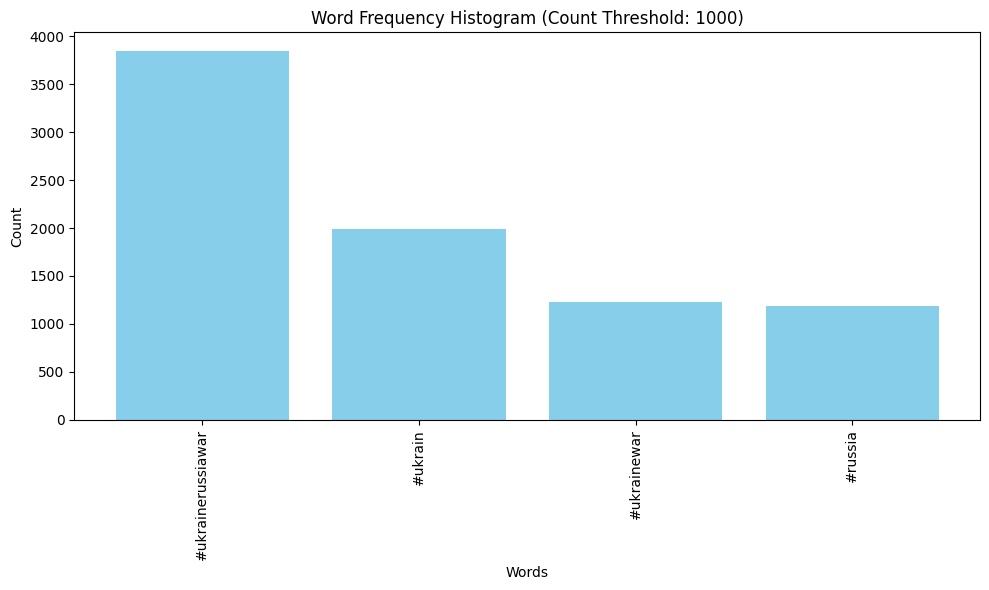

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already processed the 'lines' variable and created the 'words' dictionary

# Function to build histogram and filter by count threshold
def build_and_filter_histogram(words_dict, count_threshold):
    filtered_words = {word: count for word, count in words_dict.items() if count >= count_threshold}
    sorted_filtered_words = dict(sorted(filtered_words.items(), key=lambda item: item[1], reverse=True))

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_filtered_words.keys(), sorted_filtered_words.values(), color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Count')
    plt.title(f'Word Frequency Histogram (Count Threshold: {count_threshold})')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

# Set your desired count threshold (minimum count for words to be included in the histogram)
count_threshold = 5

# Call the function to build and filter the histogram
build_and_filter_histogram(words, 1000)


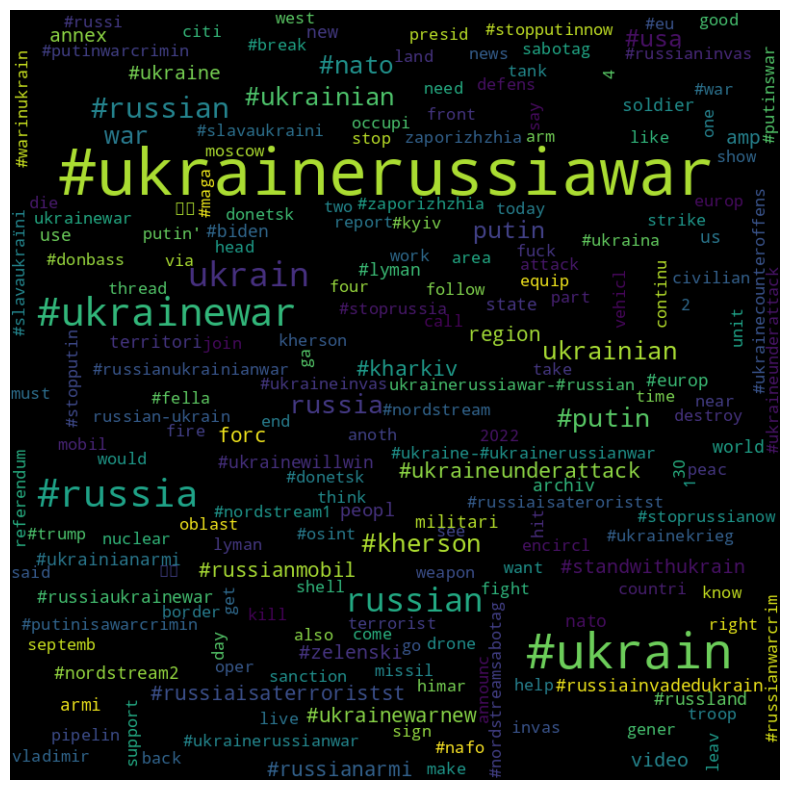

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Create the word cloud object
wc = WordCloud(width=800, height=800, background_color='black', colormap='viridis')

# Generate the word cloud from the word frequencies
wc.generate_from_frequencies(words)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


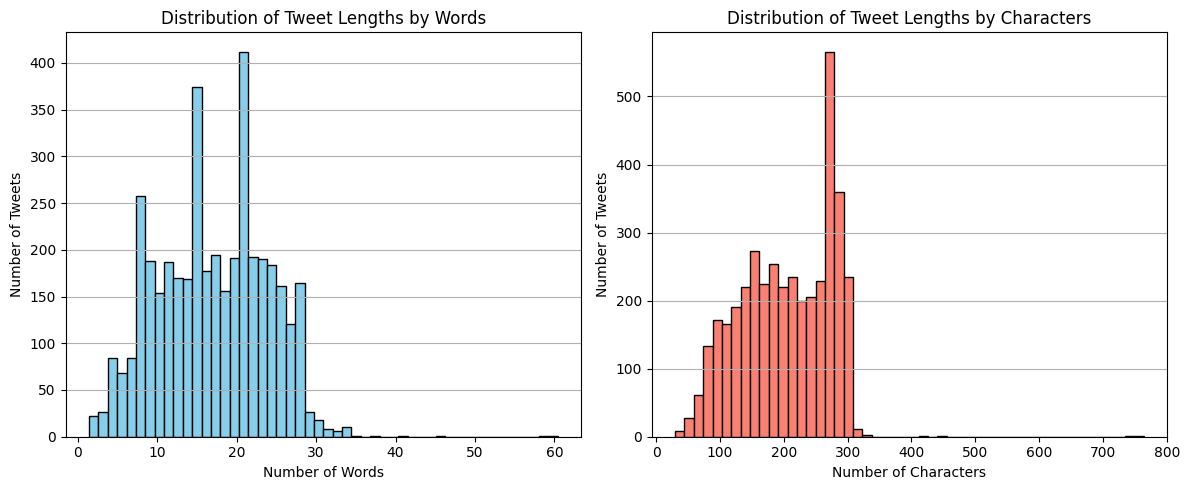

 The average length of the tweets is 18 words (211 chars)


In [ ]:
import numpy as np

tweet_lengths_words = [len(line) for line in processed_lines]
tweet_lengths_chars = [len(json.loads(line)['full_text']) for line in lines]

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot the histogram for word lengths
axs[0].hist(tweet_lengths_words, bins=50, align='left', color='skyblue', edgecolor='black')
axs[0].set_xlabel('Number of Words')
axs[0].set_ylabel('Number of Tweets')
axs[0].set_title('Distribution of Tweet Lengths by Words')
axs[0].grid(axis='y')

# Plot the histogram for character lengths
axs[1].hist(tweet_lengths_chars, bins=50, align='left', color='salmon', edgecolor='black')
axs[1].set_xlabel('Number of Characters')
axs[1].set_ylabel('Number of Tweets')
axs[1].set_title('Distribution of Tweet Lengths by Characters')
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()

print(" The average length of the tweets is {} words ({} chars)".format(round(np.mean(tweet_lengths_words)),round(np.mean(tweet_lengths_chars))))

In [ ]:
# Sort the tweets based on retweet_count
sorted_tweets = sorted(lines, key=lambda x: json.loads(x)['retweet_count'], reverse=True)

# Display the top 10 tweets with most retweets
for i, tweet in enumerate(sorted_tweets[:10]):
    print("{}.- {} \n\n(Retweets: {})\n\n".format(i+1, json.loads(tweet)['full_text'], json.loads(tweet)['retweet_count']))


1.- 🗺️Situation around Lyman - Sep 30 11:00:
- UA forces liberated Yampil and advancing north
- RU troops are reportedly abandoning its positions in Drobysheve
- The only exit route from Lyman is within the firing range of UA forces
#UkraineRussiaWar https://t.co/jGJUhXcr1y 

(Retweets: 646)


2.- 📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.
#UkraineRussiaWar https://t.co/AmSijyM59c 

(Retweets: 338)


3.- 📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canadian instructors in the UK.
#UkraineRussiaWar https://t.co/oYWThs8qNe 

(Retweets: 283)


4.- The following countries have urged their citizens to leave 🇷🇺 will update if other governments make similar statements. 
#UkraineRussiaWar #AnnexationofUkraine
#NAFO 

Poland 🇵🇱
Estonia 🇪🇪
Latvia 🇱🇻
Italy 🇮🇹
United States 🇺🇲
Bulgaria 🇧🇬
Roma

In [ ]:
# Sort the tweets based on favorite_count
sorted_tweets = sorted(lines, key=lambda x: json.loads(x)['favorite_count'], reverse=True)

# Display the top 10 tweets with most favorites
for i, tweet in enumerate(sorted_tweets[:10]):
    print("{}.- {} \n\n(Favorite: {})\n\n".format(i+1, json.loads(tweet)['full_text'], json.loads(tweet)['favorite_count']))

1.- 🗺️Situation around Lyman - Sep 30 11:00:
- UA forces liberated Yampil and advancing north
- RU troops are reportedly abandoning its positions in Drobysheve
- The only exit route from Lyman is within the firing range of UA forces
#UkraineRussiaWar https://t.co/jGJUhXcr1y 

(Favorite: 3701)


2.- 📷Unique and rare photos of Ukrainian forward command post during the offensive in #Kharkiv Oblast. News reporters aren't usually invited to such places, but here seems to be an exception.
#UkraineRussiaWar https://t.co/AmSijyM59c 

(Favorite: 2685)


3.- 📽️Operation Interflex: Ukrainian recruits continue to master their skills under the guidance of British and Canadian instructors in the UK.
#UkraineRussiaWar https://t.co/oYWThs8qNe 

(Favorite: 2155)


4.- 📷🇨🇿 Czech volunteer during the ongoing offensive of Ukrainian Forces in #Kharkiv Oblast. #UkraineRussiaWar https://t.co/u9tnLGvXlw 

(Favorite: 1631)


5.- 📽️🇺🇦 Ukrainian forces liberated Drobysheve in #Donetsk Oblast. 
#UkraineRussiaWar 

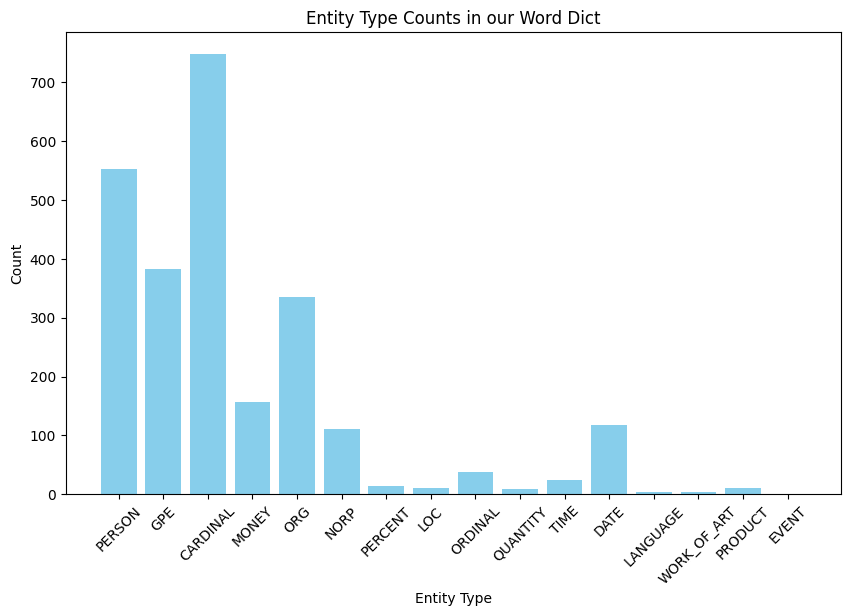

In [43]:
import spacy
from collections import defaultdict

nlp = spacy.load("en_core_web_sm")

# Function to perform entity recognition for a given text
def perform_entity_recognition(text):
    doc = nlp(text)
    if doc.ents:
      entities = [ent.label_ for ent in doc.ents]
      return entities
    return 0

# Perform entity recognition for each word in processed_lines
entity_counts = defaultdict(int)

for key in words.keys():
    entity = perform_entity_recognition(key)
    if entity != 0:
      if entity[0] in entity_counts:
        entity_counts[entity[0]] += 1
      else:
        entity_counts[entity[0]] = 1


# Visualize entity type counts in a histogram
plt.figure(figsize=(10, 6))
plt.bar(entity_counts.keys(), entity_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title('Entity Type Counts in our Word Dict')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.show()

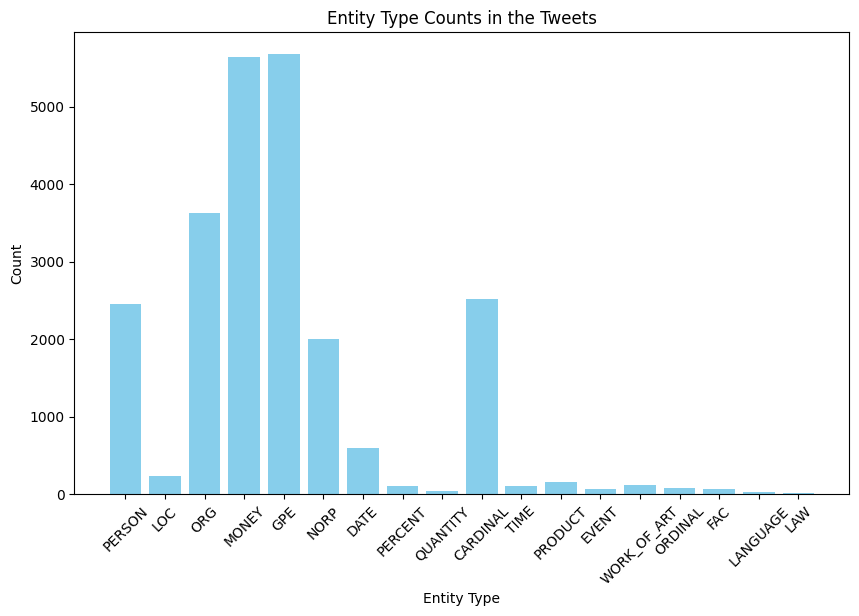

In [44]:
import spacy
from collections import defaultdict

nlp = spacy.load("en_core_web_sm")

# Function to perform entity recognition for a given text
def perform_entity_recognition(text):
    doc = nlp(text)
    if doc.ents:
      entities = [ent.label_ for ent in doc.ents]
      return entities
    return 0

# Perform entity recognition for each word in processed_lines
entity_counts = defaultdict(int)

for line in lines:
    json_data = json.loads(line)
    entities = perform_entity_recognition(json_data['full_text'])
    if entities != 0:
      for entity in entities:
        if entity in entity_counts:
          entity_counts[entity] += 1
        else:
          entity_counts[entity] = 1


# Visualize entity type counts in a histogram
plt.figure(figsize=(10, 6))
plt.bar(entity_counts.keys(), entity_counts.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title('Entity Type Counts in the Tweets')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.show()